<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/LAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Tewabe Melkamu

Date: 3/13/2025

LAI_Data Collection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-mftewabe')

# Loop data download

In [3]:
# -------------------------------------------------------------------
# 1. Define the study region (Taiwan)
# -------------------------------------------------------------------
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load ESA WorldCover and create a mask
# -------------------------------------------------------------------
# worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)
# mask = worldcover.neq(50).And(worldcover.neq(80))  # Remove built-up and water

# -------------------------------------------------------------------
# 3. Define Seasons
# -------------------------------------------------------------------
seasons = {
    "Spring": ('03-01', '05-31'),
    "Summer": ('06-01', '08-31'),
    "Autumn": ('09-01', '11-30'),
    "Winter": ('12-01', '02-28')  # Winter spans two years
}

# -------------------------------------------------------------------
# 4. Loop through each year and export seasonal LAI
# -------------------------------------------------------------------
for year in range(2000, 2025):
    print(f"Processing year: {year}")

    for season, (start, end) in seasons.items():
        print(f"  Processing {season} of {year}")

        if season == "Winter":
            # Winter spans two years
            start_date = ee.Date(f"{year}-12-01")
            end_date = ee.Date(f"{year + 1}-02-28")  # Move to next year
        else:
            start_date = ee.Date(f"{year}-{start}")
            end_date = ee.Date(f"{year}-{end}")

        # Compute seasonal mean LAI
        LAI = (ee.ImageCollection("MODIS/061/MOD15A2H")
                .filterDate(start_date, end_date)
                .filterBounds(taiwan)
                .select('Lai_500m')
                .mean()
                .clip(taiwan))

        # Convert raw LAI values using MODIS scale factor (0.1)
        LAI_scaled = LAI.multiply(0.1).clamp(0, 7.5)


        # # Apply land mask
        # LAI_masked = LAI_scaled.updateMask(mask)

        # Export to Google Drive
        task = ee.batch.Export.image.toDrive(
            image=LAI_scaled,
            description=f'LAI_{year}_{season}',
            folder='LAI',  # Update this to your desired Drive folder
            fileNamePrefix=f'LAI_{year}_{season}',
            region=taiwan.geometry().bounds().getInfo()['coordinates'],
            scale=1000,  # MODIS resolution (~1 km)
            crs='EPSG:32651',
            maxPixels=1e13
        )

        task.start()
        print(f"Export task for {year} - {season} started. ")


Processing year: 2000
  Processing Spring of 2000
Export task for 2000 - Spring started. 
  Processing Summer of 2000
Export task for 2000 - Summer started. 
  Processing Autumn of 2000
Export task for 2000 - Autumn started. 
  Processing Winter of 2000
Export task for 2000 - Winter started. 
Processing year: 2001
  Processing Spring of 2001
Export task for 2001 - Spring started. 
  Processing Summer of 2001
Export task for 2001 - Summer started. 
  Processing Autumn of 2001
Export task for 2001 - Autumn started. 
  Processing Winter of 2001
Export task for 2001 - Winter started. 
Processing year: 2002
  Processing Spring of 2002
Export task for 2002 - Spring started. 
  Processing Summer of 2002
Export task for 2002 - Summer started. 
  Processing Autumn of 2002
Export task for 2002 - Autumn started. 
  Processing Winter of 2002
Export task for 2002 - Winter started. 
Processing year: 2003
  Processing Spring of 2003
Export task for 2003 - Spring started. 
  Processing Summer of 2003


# Data exploration

In [4]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 66.6 MB/s eta 0:00:00


Metadata:
driver: GTiff
dtype: float64
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


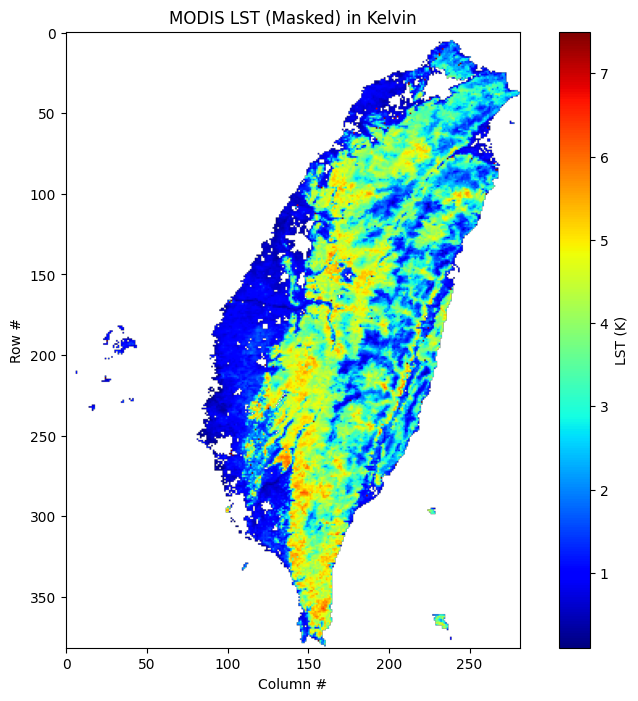

In [6]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/LAI (3)/LAI_2016_Spring.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
ndvi_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(ndvi_masked, cmap=cmap)
plt.colorbar(img, label='LST (K)')
plt.title('MODIS LST (Masked) in Kelvin')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()



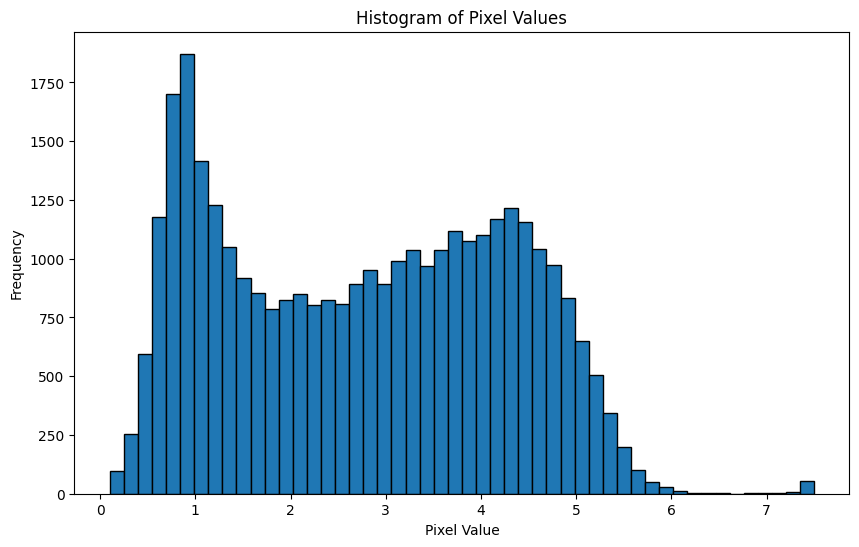

In [7]:
# prompt: HISTOGRAM OF

import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Path to the downloaded GeoTIFF file.  This should be updated to the actual path.
filename = '/content/drive/MyDrive/LAI (3)/LAI_2016_Spring.tif'

try:
    # Open the file with rasterio
    with rasterio.open(filename) as src:
        # Read the first band
        data = src.read(1)

        # Mask no-data values
        masked_data = np.ma.masked_where(data == src.nodata, data)

        # Create the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(masked_data.compressed(), bins=50, edgecolor='black')  # Use masked_data.compressed() for valid values
        plt.title('Histogram of Pixel Values')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.show()

except FileNotFoundError:
    print(f"Error: File not found at {filename}")
except rasterio.errors.RasterioIOError:
    print(f"Error: Could not open the file {filename} with rasterio. Please check the file path and format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
